In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pyfiles.models as models
import pyfiles.lib as lib

In [2]:
data_shape = (1, 128, 128)
num_noise = batch_size = 64
epochs = 200
hidden_layer_num = 400

ld = 10
category={0: 'boxingmoving', 
          1: 'boxingstill', 
          2: 'crawling', 
          3: 'running', 
          4: 'still', 
          5: 'walking', 
          6: 'walkinglow'}

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
data_path='./data/RADAR'

### Get RADAR DATA
train_data, train_labels, test_data, test_labels = lib.RADARLoader(data_path, category, device, "")

tasks = train_data.shape[0]
### Normalize data to [-1, 1]
# print(train_data)
train_data = lib.tensor_normalize(train_data)
# train_labels = lib.tensor_normalize(train_labels)
test_data = lib.tensor_normalize(test_data)
print(tasks)

Train Data Shape:  torch.Size([12, 7, 9, 128, 128])
Test Data Shape:  torch.Size([12, 7, 3, 128, 128])
Train Label Shape:  torch.Size([7, 9])
Test Label Shape:  torch.Size([7, 3])
12


### Fisher

In [3]:
hidden_layer_num = 1000
epochs = 300
ld_list=[100, 300, 1000, 3000]
ewc_acc = {}

for ld in ld_list:
    print("Lambda %f"%(ld))
    net = models.ConvolutionNetwork().to(device)
#     net = models.FCNetwork(data_shape, hidden_layer_num, 7).to(device)
    lib.init_params(net)
    crit = torch.nn.CrossEntropyLoss()

    past_task_params = []
    past_fisher_mat = []
    optim = torch.optim.Adam(net.parameters(), lr=0.001)
    ewc_acc_per_ld = {}
    
    for task in range(tasks):
        net.train()
        for epoch in range(epochs):
            running_loss = 0.0
            x = train_data[task].view(-1, 1, 128, 128)
#             x = train_data[task].view(-1, 128*128)
            seed = torch.randperm(x.shape[0])
            x = x[seed]
            y = train_labels.view(-1)[seed]
#             print(x.shape, y.shape)

            optim.zero_grad()
            net.zero_grad()
            outputs = net(x)
            loss = crit(outputs, y)

            reg = 0.0
            for _task, past_param in enumerate(past_task_params):
                for i, param in enumerate(net.parameters()):
                    penalty = (past_param[i] - param) ** 2
                    penalty *= past_fisher_mat[_task][i]
                    reg += penalty.sum()
                loss += reg * (ld / 2)

            loss.backward()
            optim.step()
            running_loss += loss.item()

            if epoch % 50 == 49:
                print("[Epoch %d/%d] Loss: %.3f"%(epoch+1, epochs, running_loss))

        ### Save parameters to use at next task learning
        tensor_param = []
        for params in net.parameters():
            tensor_param.append(params.detach().clone())
        past_task_params.append(tensor_param)

        ### Save Fisher matrix
#         print(train_data[:task+1].shape)
#         x = train_data[:task+1].view(-1, 1, 128, 128)
#         y = train_labels.view(-1)
#         print(x.shape)
        FisherMatrix = lib.get_fisher(net, crit, (train_data[:task+1], train_labels))
#         print(past_fisher_mat)
        past_fisher_mat.append(FisherMatrix)

        ## Evaluation
        each_task_acc = torch.zeros((task+1, )).to(device)

        net.eval()
        for t in range(task+1):
            total = 0.0
            correct = 0.0
            x = test_data[t].view(-1, 1, 128, 128)
#             x = test_data[t].view(-1, 128 * 128)
            y = test_labels.view(-1)
            
            outputs = net(x)
            _, predicted = torch.max(outputs, dim=1)
            total += x.shape[0]

            correct += (predicted == y).sum()

            each_task_acc[t] = (correct / total) * 100

        acc_mean = torch.mean(each_task_acc)
        print('[Task %d] avg accuracy: %.3f%%'%(task+1, acc_mean))
        print(each_task_acc)
        
        ewc_acc_per_ld[t] = acc_mean
        
    ewc_acc[ld] = ewc_acc_per_ld

Lambda 100.000000
[Epoch 50/300] Loss: 0.296
[Epoch 100/300] Loss: 0.131
[Epoch 150/300] Loss: 0.033
[Epoch 200/300] Loss: 0.003
[Epoch 250/300] Loss: 0.012
[Epoch 300/300] Loss: 0.005
[Task 1] avg accuracy: 76.190%
tensor([76.1905], device='cuda:2')
[Epoch 50/300] Loss: 0.111
[Epoch 100/300] Loss: 0.008
[Epoch 150/300] Loss: 0.004
[Epoch 200/300] Loss: 0.002
[Epoch 250/300] Loss: 0.001
[Epoch 300/300] Loss: 0.001
[Task 2] avg accuracy: 73.810%
tensor([71.4286, 76.1905], device='cuda:2')
[Epoch 50/300] Loss: 0.195
[Epoch 100/300] Loss: 0.023
[Epoch 150/300] Loss: 0.038
[Epoch 200/300] Loss: 0.012
[Epoch 250/300] Loss: 0.010
[Epoch 300/300] Loss: 0.010
[Task 3] avg accuracy: 77.778%
tensor([57.1429, 85.7143, 90.4762], device='cuda:2')
[Epoch 50/300] Loss: 0.098
[Epoch 100/300] Loss: 0.057
[Epoch 150/300] Loss: 0.071
[Epoch 200/300] Loss: 0.068
[Epoch 250/300] Loss: 0.033
[Epoch 300/300] Loss: 0.035
[Task 4] avg accuracy: 75.000%
tensor([57.1429, 66.6667, 80.9524, 95.2381], device='cuda:

[Epoch 50/300] Loss: 0.533
[Epoch 100/300] Loss: 0.322
[Epoch 150/300] Loss: 0.247
[Epoch 200/300] Loss: 0.248
[Epoch 250/300] Loss: 0.219
[Epoch 300/300] Loss: 0.233
[Task 6] avg accuracy: 74.603%
tensor([71.4286, 66.6667, 61.9048, 76.1905, 80.9524, 90.4762], device='cuda:2')
[Epoch 50/300] Loss: 0.571
[Epoch 100/300] Loss: 0.367
[Epoch 150/300] Loss: 0.313
[Epoch 200/300] Loss: 0.296
[Epoch 250/300] Loss: 0.396
[Epoch 300/300] Loss: 0.363
[Task 7] avg accuracy: 71.429%
tensor([ 80.9524,  61.9048,  52.3810,  61.9048,  66.6667,  76.1905, 100.0000],
       device='cuda:2')
[Epoch 50/300] Loss: 0.527
[Epoch 100/300] Loss: 0.516
[Epoch 150/300] Loss: 0.526
[Epoch 200/300] Loss: 0.405
[Epoch 250/300] Loss: 0.421
[Epoch 300/300] Loss: 0.391
[Task 8] avg accuracy: 77.381%
tensor([76.1905, 76.1905, 52.3810, 76.1905, 95.2381, 71.4286, 85.7143, 85.7143],
       device='cuda:2')
[Epoch 50/300] Loss: 1.057
[Epoch 100/300] Loss: 0.986
[Epoch 150/300] Loss: 0.793
[Epoch 200/300] Loss: 0.714
[Epoch 

In [ ]:
Lambda 100.000000
[Epoch 50/100] Loss: 0.006
[Epoch 100/100] Loss: 0.001
[Task 1] avg accuracy: 76.190%
tensor([76.1905], device='cuda:2')
[Epoch 50/100] Loss: 0.001
[Epoch 100/100] Loss: 0.000
[Task 2] avg accuracy: 73.810%
tensor([57.1429, 90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.017
[Epoch 100/100] Loss: 0.008
[Task 3] avg accuracy: 76.190%
tensor([57.1429, 80.9524, 90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.042
[Epoch 100/100] Loss: 0.024
[Task 4] avg accuracy: 82.143%
tensor([61.9048, 85.7143, 90.4762, 90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.081
[Epoch 100/100] Loss: 0.043
[Task 5] avg accuracy: 84.762%
tensor([76.1905, 85.7143, 76.1905, 90.4762, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.114
[Epoch 100/100] Loss: 0.072
[Task 6] avg accuracy: 80.952%
tensor([76.1905, 76.1905, 76.1905, 85.7143, 85.7143, 85.7143], device='cuda:2')
[Epoch 50/100] Loss: 0.129
[Epoch 100/100] Loss: 0.082
[Task 7] avg accuracy: 78.231%
tensor([80.9524, 71.4286, 76.1905, 71.4286, 85.7143, 76.1905, 85.7143],
       device='cuda:2')
[Epoch 50/100] Loss: 0.136
[Epoch 100/100] Loss: 0.097
[Task 8] avg accuracy: 82.738%
tensor([ 71.4286,  80.9524,  85.7143,  76.1905,  95.2381,  76.1905,  76.1905,
        100.0000], device='cuda:2')
[Epoch 50/100] Loss: 0.266
[Epoch 100/100] Loss: 0.175
[Task 9] avg accuracy: 72.487%
tensor([ 57.1429,  80.9524,  71.4286,  57.1429,  80.9524,  66.6667,  57.1429,
         80.9524, 100.0000], device='cuda:2')
[Epoch 50/100] Loss: 0.211
[Epoch 100/100] Loss: 0.156
[Task 10] avg accuracy: 84.286%
tensor([ 76.1905,  76.1905,  85.7143,  80.9524,  85.7143,  76.1905,  90.4762,
         80.9524,  90.4762, 100.0000], device='cuda:2')
[Epoch 50/100] Loss: 0.201
[Epoch 100/100] Loss: 0.181
[Task 11] avg accuracy: 83.550%
tensor([76.1905, 80.9524, 76.1905, 85.7143, 80.9524, 80.9524, 80.9524, 80.9524,
        85.7143, 95.2381, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.282
[Epoch 100/100] Loss: 0.232
[Task 12] avg accuracy: 82.540%
tensor([ 66.6667,  80.9524,  76.1905,  85.7143,  90.4762,  80.9524,  76.1905,
         80.9524,  71.4286, 100.0000,  90.4762,  90.4762], device='cuda:2')
Lambda 300.000000
[Epoch 50/100] Loss: 0.013
[Epoch 100/100] Loss: 0.001
[Task 1] avg accuracy: 90.476%
tensor([90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.001
[Epoch 100/100] Loss: 0.000
[Task 2] avg accuracy: 64.286%
tensor([47.6190, 80.9524], device='cuda:2')
[Epoch 50/100] Loss: 0.033
[Epoch 100/100] Loss: 0.016
[Task 3] avg accuracy: 73.016%
tensor([57.1429, 66.6667, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.098
[Epoch 100/100] Loss: 0.056
[Task 4] avg accuracy: 70.238%
tensor([66.6667, 47.6190, 80.9524, 85.7143], device='cuda:2')
[Epoch 50/100] Loss: 0.133
[Epoch 100/100] Loss: 0.084
[Task 5] avg accuracy: 79.048%
tensor([80.9524, 80.9524, 71.4286, 66.6667, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.183
[Epoch 100/100] Loss: 0.126
[Task 6] avg accuracy: 76.984%
tensor([71.4286, 61.9048, 76.1905, 80.9524, 80.9524, 90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.177
[Epoch 100/100] Loss: 0.142
[Task 7] avg accuracy: 78.912%
tensor([66.6667, 66.6667, 90.4762, 71.4286, 95.2381, 71.4286, 90.4762],
       device='cuda:2')
[Epoch 50/100] Loss: 0.188
[Epoch 100/100] Loss: 0.164
[Task 8] avg accuracy: 79.167%
tensor([66.6667, 66.6667, 95.2381, 71.4286, 85.7143, 66.6667, 90.4762, 90.4762],
       device='cuda:2')
[Epoch 50/100] Loss: 0.373
[Epoch 100/100] Loss: 0.260
[Task 9] avg accuracy: 70.370%
tensor([57.1429, 66.6667, 61.9048, 66.6667, 80.9524, 76.1905, 52.3810, 76.1905,
        95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.353
[Epoch 100/100] Loss: 0.289
[Task 10] avg accuracy: 73.333%
tensor([61.9048, 61.9048, 80.9524, 71.4286, 80.9524, 71.4286, 85.7143, 61.9048,
        71.4286, 85.7143], device='cuda:2')
[Epoch 50/100] Loss: 0.446
[Epoch 100/100] Loss: 0.367
[Task 11] avg accuracy: 77.056%
tensor([ 71.4286,  66.6667,  85.7143,  80.9524,  85.7143,  76.1905,  85.7143,
         61.9048,  71.4286,  61.9048, 100.0000], device='cuda:2')
[Epoch 50/100] Loss: 0.545
[Epoch 100/100] Loss: 0.434
[Task 12] avg accuracy: 75.794%
tensor([71.4286, 66.6667, 80.9524, 76.1905, 85.7143, 76.1905, 85.7143, 66.6667,
        66.6667, 61.9048, 80.9524, 90.4762], device='cuda:2')
Lambda 1000.000000
[Epoch 50/100] Loss: 0.012
[Epoch 100/100] Loss: 0.002
[Task 1] avg accuracy: 80.952%
tensor([80.9524], device='cuda:2')
[Epoch 50/100] Loss: 0.004
[Epoch 100/100] Loss: 0.006
[Task 2] avg accuracy: 69.048%
tensor([52.3810, 85.7143], device='cuda:2')
[Epoch 50/100] Loss: 0.002
[Epoch 100/100] Loss: 0.001
[Task 3] avg accuracy: 80.952%
tensor([76.1905, 71.4286, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.066
[Epoch 100/100] Loss: 0.023
[Task 4] avg accuracy: 83.333%
tensor([ 76.1905,  71.4286, 100.0000,  85.7143], device='cuda:2')
[Epoch 50/100] Loss: 0.073
[Epoch 100/100] Loss: 0.037
[Task 5] avg accuracy: 86.667%
tensor([76.1905, 80.9524, 90.4762, 90.4762, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.167
[Epoch 100/100] Loss: 0.081
[Task 6] avg accuracy: 76.984%
tensor([76.1905, 71.4286, 76.1905, 80.9524, 80.9524, 76.1905], device='cuda:2')
[Epoch 50/100] Loss: 0.131
[Epoch 100/100] Loss: 0.090
[Task 7] avg accuracy: 78.912%
tensor([80.9524, 66.6667, 80.9524, 76.1905, 80.9524, 71.4286, 95.2381],
       device='cuda:2')
[Epoch 50/100] Loss: 0.146
[Epoch 100/100] Loss: 0.121
[Task 8] avg accuracy: 85.119%
tensor([ 80.9524,  76.1905,  95.2381,  80.9524,  90.4762,  66.6667, 100.0000,
         90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.339
[Epoch 100/100] Loss: 0.232
[Task 9] avg accuracy: 72.487%
tensor([52.3810, 71.4286, 76.1905, 61.9048, 71.4286, 80.9524, 61.9048, 85.7143,
        90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.310
[Epoch 100/100] Loss: 0.263
[Task 10] avg accuracy: 80.476%
tensor([80.9524, 71.4286, 80.9524, 80.9524, 80.9524, 80.9524, 90.4762, 76.1905,
        71.4286, 90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.331
[Epoch 100/100] Loss: 0.377
[Task 11] avg accuracy: 81.385%
tensor([ 76.1905,  76.1905,  80.9524,  90.4762,  76.1905,  80.9524,  80.9524,
         80.9524,  71.4286,  80.9524, 100.0000], device='cuda:2')
[Epoch 50/100] Loss: 0.609
[Epoch 100/100] Loss: 0.485
[Task 12] avg accuracy: 78.968%
tensor([80.9524, 76.1905, 90.4762, 80.9524, 80.9524, 71.4286, 80.9524, 80.9524,
        61.9048, 76.1905, 85.7143, 80.9524], device='cuda:2')
Lambda 3000.000000
[Epoch 50/100] Loss: 0.002
[Epoch 100/100] Loss: 0.000
[Task 1] avg accuracy: 80.952%
tensor([80.9524], device='cuda:2')
[Epoch 50/100] Loss: 0.000
[Epoch 100/100] Loss: 0.000
[Task 2] avg accuracy: 69.048%
tensor([61.9048, 76.1905], device='cuda:2')
[Epoch 50/100] Loss: 0.026
[Epoch 100/100] Loss: 0.014
[Task 3] avg accuracy: 80.952%
tensor([66.6667, 80.9524, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.092
[Epoch 100/100] Loss: 0.048
[Task 4] avg accuracy: 79.762%
tensor([76.1905, 66.6667, 80.9524, 95.2381], device='cuda:2')
[Epoch 50/100] Loss: 0.153
[Epoch 100/100] Loss: 0.115
[Task 5] avg accuracy: 88.571%
tensor([ 90.4762,  85.7143,  80.9524,  85.7143, 100.0000], device='cuda:2')
[Epoch 50/100] Loss: 0.242
[Epoch 100/100] Loss: 0.124
[Task 6] avg accuracy: 78.571%
tensor([80.9524, 76.1905, 61.9048, 85.7143, 80.9524, 85.7143], device='cuda:2')
[Epoch 50/100] Loss: 0.220
[Epoch 100/100] Loss: 0.180
[Task 7] avg accuracy: 76.871%
tensor([85.7143, 71.4286, 61.9048, 66.6667, 85.7143, 80.9524, 85.7143],
       device='cuda:2')
[Epoch 50/100] Loss: 0.463
[Epoch 100/100] Loss: 0.314
[Task 8] avg accuracy: 79.167%
tensor([ 80.9524,  76.1905,  80.9524,  71.4286, 100.0000,  66.6667,  80.9524,
         76.1905], device='cuda:2')
[Epoch 50/100] Loss: 0.487
[Epoch 100/100] Loss: 0.406
[Task 9] avg accuracy: 71.958%
tensor([80.9524, 71.4286, 71.4286, 52.3810, 85.7143, 71.4286, 52.3810, 71.4286,
        90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.540
[Epoch 100/100] Loss: 0.481
[Task 10] avg accuracy: 78.095%
tensor([90.4762, 80.9524, 76.1905, 66.6667, 90.4762, 71.4286, 80.9524, 57.1429,
        76.1905, 90.4762], device='cuda:2')
[Epoch 50/100] Loss: 0.779
[Epoch 100/100] Loss: 0.605
[Task 11] avg accuracy: 71.861%
tensor([85.7143, 71.4286, 61.9048, 52.3810, 76.1905, 76.1905, 76.1905, 52.3810,
        76.1905, 71.4286, 90.4762], device='cuda:2')

[Epoch 50/100] Loss: 0.916
[Epoch 100/100] Loss: 0.775
[Task 12] avg accuracy: 74.206%
tensor([80.9524, 66.6667, 66.6667, 66.6667, 80.9524, 76.1905, 71.4286, 61.9048,
        71.4286, 76.1905, 85.7143, 85.7143], device='cuda:2')


In [4]:
print(ewc_acc)

{100: {0: tensor(76.1905, device='cuda:2'), 1: tensor(73.8095, device='cuda:2'), 2: tensor(79.3651, device='cuda:2'), 3: tensor(80.9524, device='cuda:2'), 4: tensor(81.9048, device='cuda:2'), 5: tensor(77.7778, device='cuda:2'), 6: tensor(79.5918, device='cuda:2'), 7: tensor(83.3333, device='cuda:2'), 8: tensor(69.8413, device='cuda:2'), 9: tensor(80.4762, device='cuda:2'), 10: tensor(77.0563, device='cuda:2'), 11: tensor(75.7937, device='cuda:2')}, 300: {0: tensor(85.7143, device='cuda:2'), 1: tensor(69.0476, device='cuda:2'), 2: tensor(73.0159, device='cuda:2'), 3: tensor(80.9524, device='cuda:2'), 4: tensor(85.7143, device='cuda:2'), 5: tensor(83.3333, device='cuda:2'), 6: tensor(85.7143, device='cuda:2'), 7: tensor(85.1190, device='cuda:2'), 8: tensor(77.2487, device='cuda:2'), 9: tensor(83.3333, device='cuda:2'), 10: tensor(79.6537, device='cuda:2'), 11: tensor(83.7302, device='cuda:2')}, 1000: {0: tensor(80.9524, device='cuda:2'), 1: tensor(78.5714, device='cuda:2'), 2: tensor(73

100
300
1000
3000


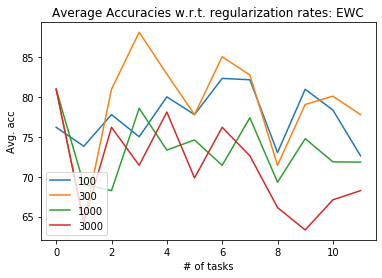

In [4]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in ewc_acc.items():
    print(coef)
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

# x, y = list(ewc_acc.keys()), list(ewc_acc.values())
# plt.plot(x, y, label=str(coef))
plt.legend(loc=3)
plt.show()

In [5]:
# 전에 했던거
print(ewc_acc)

{100: {0: tensor(76.1905, device='cuda:2'), 1: tensor(73.8095, device='cuda:2'), 2: tensor(76.1905, device='cuda:2'), 3: tensor(82.1429, device='cuda:2'), 4: tensor(84.7619, device='cuda:2'), 5: tensor(80.9524, device='cuda:2'), 6: tensor(78.2313, device='cuda:2'), 7: tensor(82.7381, device='cuda:2'), 8: tensor(72.4868, device='cuda:2'), 9: tensor(84.2857, device='cuda:2'), 10: tensor(83.5498, device='cuda:2'), 11: tensor(82.5397, device='cuda:2')}, 300: {0: tensor(90.4762, device='cuda:2'), 1: tensor(64.2857, device='cuda:2'), 2: tensor(73.0159, device='cuda:2'), 3: tensor(70.2381, device='cuda:2'), 4: tensor(79.0476, device='cuda:2'), 5: tensor(76.9841, device='cuda:2'), 6: tensor(78.9116, device='cuda:2'), 7: tensor(79.1667, device='cuda:2'), 8: tensor(70.3704, device='cuda:2'), 9: tensor(73.3333, device='cuda:2'), 10: tensor(77.0563, device='cuda:2'), 11: tensor(75.7937, device='cuda:2')}, 1000: {0: tensor(80.9524, device='cuda:2'), 1: tensor(69.0476, device='cuda:2'), 2: tensor(80

In [13]:
ewc_acc={0: 94.8200, 1: 95.2900, 2: 94.9000, 3: 93.0825, 4: 91.3380, 5: 89.7967, 6: 88.0786, 7: 85.6437, 8: 82.2944, 9: 79.1550}

100
300
1000
3000


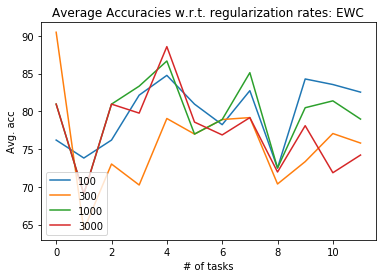

In [4]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in ewc_acc.items():
    print(coef)
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

# x, y = list(ewc_acc.keys()), list(ewc_acc.values())
# plt.plot(x, y, label=str(coef))
plt.legend(loc=3)
plt.show()

90
100
200


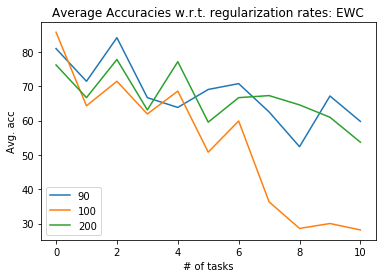

In [12]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in ewc_acc.items():
    print(coef)
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

# x, y = list(ewc_acc.keys()), list(ewc_acc.values())
# plt.plot(x, y, label=str(coef))
plt.legend(loc=3)
plt.show()

In [17]:
l2_acc = {0: 94.7500, 1: 94.6050, 2: 93.5800, 3: 91.6275, 4: 86.9860, 5: 83.2583, 6: 80.3400, 7: 79.0625, 8: 74.1244, 9: 72.2690}

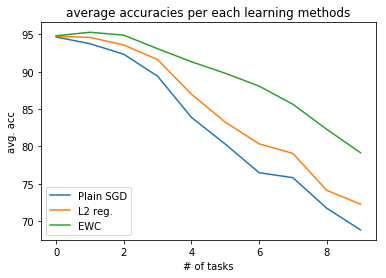

In [19]:
plt.xlabel("# of tasks")
plt.ylabel("avg. acc")
plt.title("average accuracies per each learning methods")

acc_dict = {}
acc_dict['Plain SGD'] = plain_acc
acc_dict['L2 reg.'] = l2_acc
acc_dict['EWC'] = ewc_acc

for coef, each_acc_dict in acc_dict.items():
    x, y = list(each_acc_dict.keys()), list(each_acc_dict.values())
    plt.plot(x, y, label=str(coef))

plt.legend(loc=3)
plt.show()